# GIỚI THIỆU VỀ OCR
OCR là viết tắt của cụm từ "Optical Character Recognition", được dùng để chỉ công nghệ nhận dạng ký tự quang học. Đây là một công nghệ cho phép máy tính quét, phân tích và chuyển đổi các hình ảnh chứa ký tự, chữ viết tay, số và các ký hiệu thành văn bản có thể chỉnh sửa được. OCR có thể được sử dụng để chuyển đổi các tài liệu được in hoặc viết tay thành định dạng kỹ thuật số, giúp cho việc lưu trữ, truyền tải và xử lý tài liệu dễ dàng hơn. OCR cũng có thể được sử dụng để giúp cho các ứng dụng nhận dạng chữ viết tay, như viết chữ trên bảng trắng hoặc nhận dạng chữ trong ảnh.

# Import module

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os
import json
import sys

In [3]:
# Dùng để in ra tiến trình xử lý
def print_progress(index, total, text):
    sys.stdout.write('\r')
    sys.stdout.write('processing ' + text + ' ')
    sys.stdout.write(str(round(index*100/total, 1))+'%')
    sys.stdout.flush()

In [4]:
import cv2
import matplotlib.pyplot as plt

# hàm dùng để show ảnh
def cv2_imshow(bgr_img):
    img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
def show_from_sub_img(sub_imgs):
    img = sub_imgs[0]
    for i in range(1, sub_imgs.shape[0]):
        img = np.concatenate([img, sub_imgs[i]], axis=1)
    plt.imshow(img)
    plt.show()

# đọc và chuyển ảnh thành nhị phân
def read_convert_img(filename):
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    return 255-binary

# đưa ảnh về thành size chuẩn height
def resize(img, expected_height=32, min_width=32, max_width=512):
    h, w = img.shape

    new_w = int(expected_height * float(w) / float(h))
    new_w = max(new_w, min_width)
    new_w = max(new_w, max_width)

    img = cv2.resize(img, (new_w, expected_height), interpolation = cv2.INTER_AREA)
    return img

# xóa khoảng trắng bên trái và bên phải
def strip_img(img):
    h, w = img.shape
    # duyệt từ trái sang phải đến khi đụng chữ
    s_cut_point = 0
    for i in range(0, w, 1):
        if True in set(img[:,i] >  0): # các điểm không phải là trắng
            s_cut_point = i
            break
    # duyệt từ phải sang trái đến khi đụng chữ
    e_cut_point = w
    for i in range(w-1, 0, -1):
        if True in set(img[:,i] >  0): # các điểm không phải là trắng
            e_cut_point = i
            break
    return img[:,s_cut_point:e_cut_point]

# cắt ảnh ra thành từng ảnh nhỏ
def cut_img(img):
    h, w = img.shape
    step = 9
    sub_imgs = []
    for i in range(step, w, step): # w, h = 10, 32
        sub_img = img[:,i-step:i]
        sub_imgs.append(sub_img)
        if i+step > w:
            sub_img = img[:,w-step:w]
            sub_imgs.append(sub_img)
    return sub_imgs

def process_image(filename):
    binary = read_convert_img(filename)
    img = resize(binary)
    img = strip_img(img)
    sub_imgs = cut_img(img)
    return np.asarray(sub_imgs)

In [5]:
# VectorizeChar để chuyển các char trong text thành vector id ký tự
class VectorizeChar:
    def __init__(self, max_len=50):
        self.vocab = (
            [str(i) for i in range(10)]
            + ["<", ">", "-", "#", "/", " ", ".", ",", "?", "!"]
            + [chr(i + 96) for i in range(1, 27)]
            + ["đ","â", "ă", "ê", "ô", "ơ", "ư", "à", "ằ", "ầ", "è", "ề", "ò", "ồ", "ờ", "ù", "ừ", "ì", "ỳ", "á", "ắ", "ấ", "é", "ế", "ó", "ố", "ớ", "ú", "ứ", "í", "ý", "ả", "ẳ", "ẩ", "ẻ", "ể", "ỏ", "ổ", "ở", "ủ", "ử", "ỉ", "ỷ", "ã", "ẵ", "ẫ", "ẽ", "ễ", "õ", "ỗ", "ỡ", "ũ", "ữ", "ĩ", "ỹ", "ạ", "ặ", "ậ", "ẹ", "ệ", "ọ", "ộ", "ợ", "ụ", "ự", "ị", "ỵ"]
        )
        self.max_len = max_len
        # dữ liệu trong char_to_idx là: vocab: id
        self.char_to_idx = {}
        for i, ch in enumerate(self.vocab):
            self.char_to_idx[ch] = i

        self.vocab_size = len(self.vocab)

        
    def __call__(self, text):
        """
            input: text
            output: danh sách id của các ký tự (char)
        """
        # viết thường hết đoạn text truyền vào
        text = text.lower()
        # lấy kích thước các ký tự trong text không quá maxlen-2
        text = text[: self.max_len - 2]
        # đưa text vào trong ngoặc nhọn
        text = "<" + text + ">"
        # dùng để padding đoạn text
        pad_len = self.max_len - len(text)
        # nếu ký tự không có trong list thì mặc định là 1, sau khi bỏ đi phần sau của text thì chúng ta sẽ thêm zero array để padding
        return [self.char_to_idx.get(ch, 1) for ch in text] + [12] * pad_len

    def get_vocabulary(self):
        # output: danh sách vocab
        return self.vocab
    
    def decode(self, vector):
        text = ''
        for value in vector:
            text += self.vocab[value]
        return text

# Xử lý dữ liệu

In [40]:
ROOT_PATH =  'dataset'# 'drive/MyDrive/dataset/image-extract/dataset'
train_path = 'training'
test_path = 'testing'

with open(os.path.join(ROOT_PATH, train_path, 'labels.json'), 'r', encoding='utf8') as f:
    train_data = json.load(f)
with open(os.path.join(ROOT_PATH, test_path, 'labels.json'), 'r', encoding='utf8') as f:
    test_data = json.load(f)

'0000_samples.png': 'Số 253 đường Trần Phú, Thị trấn Nam Sách, Huyện Nam Sách, Hải Dương',
'0001_samples.png': 'Số 289 Đinh Bộ Lĩnh, Phường 26, Quận Bình Thạnh, TP Hồ Chí Minh',

img_name: img_content
-> img_value: vector_char

## Feature

In [7]:
MAX_INPUT_LEN = 70

def get_img_value(filename):
    sub_imgs = process_image(filename)
    return sub_imgs

def padding_sub_imgs(sub_imgs):
    seq_len = sub_imgs.shape[0]
    pad = np.zeros((1,32,9))
    if seq_len < MAX_INPUT_LEN:
        for _ in range(MAX_INPUT_LEN-seq_len):
            sub_imgs = np.concatenate([sub_imgs, pad], axis=0)
    return sub_imgs[:MAX_INPUT_LEN]

def get_imgs_value(data_path, dataset): 
    data = []
    idx = 1
    for img_name in dataset.keys():
        print_progress(idx, len(dataset.keys()), img_name)
        idx+=1
        path = os.path.join(ROOT_PATH, data_path, img_name)# file path
        sub_imgs = get_img_value(path) # imgs (bath, h, w)
        sub_imgs_pad = padding_sub_imgs(sub_imgs)# imgs (seq_len, h, w)
        data.append(sub_imgs_pad)
    return data
# get_imgs_value(train_path)

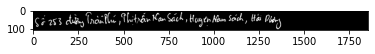

In [8]:
# kiểm tra đầu vào
img_tmp = read_convert_img('dataset/training/0000_samples.png')
cv2_imshow(img_tmp)

In [41]:
train_values =  get_imgs_value(train_path, train_data) # 20s
test_values =  get_imgs_value(test_path, test_data)

processing 0548_tests.png 100.0%

In [42]:
len(train_values), len(test_values)

(1823, 549)

# Label

In [11]:
MAX_OUTPUT_LEN = 80
vectorizer = VectorizeChar(MAX_OUTPUT_LEN) # default maxlen = 50

def get_vector_char(text):
    vector = vectorizer(text.strip())
    return vector
def get_vectors_char(dataset):
    data = []
    for text in dataset.values():
        vector = get_vector_char(text)
        data.append(vector)
    return data

In [43]:
train_labels =  get_vectors_char(train_data)
test_labels =  get_vectors_char(test_data)

In [44]:
len(train_labels), len(test_labels)

(1823, 549)

# Zip data - label

In [14]:
def create_ds(values, labels, batch_size=8):
    image = tf.data.Dataset.from_tensor_slices(values)
    label = tf.data.Dataset.from_tensor_slices(labels)

    data = tf.data.Dataset.zip((image, label))
    data = data.map(lambda x, y: {"source": x, "target": y})
    data = data.batch(batch_size)
    data = data.prefetch(tf.data.AUTOTUNE)

    return data

In [15]:
train_data = create_ds(train_values, train_labels, batch_size=6)
print(train_data)

<PrefetchDataset element_spec={'source': TensorSpec(shape=(None, 70, 32, 9), dtype=tf.float64, name=None), 'target': TensorSpec(shape=(None, 80), dtype=tf.int32, name=None)}>


# Model Transformer

In [16]:
# Các hàm quan trọng
# positional Encoding
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # sử dụng sin cho vị trí số chẵn trong mảng, 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # sử dụng cos cho vị trí số lẻ trong mảng, 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [17]:
# TokenEmbedding
class TokenEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model, 
                        input_vocab_size, # tokenizer.vocab_size
                        max_length): # max_seq_length - MAX_LENGTH
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_length, d_model)

    def call(self, x): # x(batch_size, input_seq_len)
        seq_len = tf.shape(x)[1]
        # cộng token embedding và position encoding.
        x = self.embedding(x)  # x(batch_size, input_seq_len, d_model), Input Embedding
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

        pos_enc = self.pos_encoding[:, :seq_len, :] # Positional Encoding   
        
        return x + pos_enc
    
class ImageFeatureEmbedding(tf.keras.layers.Layer):
    def __init__(self, d_model, input_shape=(32,9)):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(32, kernel_size=3, strides=1, activation="relu", padding='same', input_shape = input_shape)
        self.conv2 = tf.keras.layers.Conv1D(64, kernel_size=3, strides=1, activation="relu", padding='same')

        self.max_pooling3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), data_format='channels_first', padding='same')
        self.batch_norm = tf.keras.layers.BatchNormalization(epsilon=1e-8)

        self.reshape = tf.keras.layers.Reshape((-1, d_model))


    def call(self, x): # (batch_size, seq_len, h, w)
        x = self.conv1(x) 
        x = self.conv2(x)
        x = self.max_pooling3(x)
        x = self.reshape(x)
        return x # (batch_size, seq_len, feature_map)

# inp = np.random.randint(255, size=(1,70, 32, 9))/17
# ImageFeatureEmbedding(512)(inp)

In [18]:
# Encoder
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, 
                        num_heads, 
                        dff, 
                        rate=0.1):
        super(EncoderLayer, self).__init__()
        # sử dụng multi-head attention để tìm sự liên kết giữa các từ trong câu
        self.att = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)

        self.ffn = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    
    def call(self, x, training):
        # sub layer 1
        attn_output = self.att(x, x)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        # sub layer 2
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        # return output
        return out2

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, 
                        d_model, 
                        num_heads, 
                        dff, 
                        rate):
        super().__init__()

        self.num_layers = num_layers
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

    def call(self, x, training=False): # (batch_size, input_seq_len, d_model)
        for i in range(self.num_layers):
              x = self.enc_layers[i](x, training)
        return x  # (batch_size, input_seq_len, d_model)


In [19]:
# Decoder 
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, # embedding_dimension
                    num_heads, 
                    dff, # feed_forward_dimension
                    rate):
        super().__init__()
        
        # Khởi tạo multihead Attention
        self.self_att = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)
        self.enc_att = tf.keras.layers.MultiHeadAttention(key_dim=d_model, num_heads=num_heads)
        # Linear FNN
        self.ffn = tf.keras.Sequential(
                [
                    tf.keras.layers.Dense(dff, activation="relu"),
                    tf.keras.layers.Dense(d_model),
                ]
            )
        
        # Add Norm
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # Dropout
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        # nếu ta sử dụng Multi-head attention trên cả câu như ở Encoder, 
        # Decoder sẽ nhận luôn từ tiếp theo mà nó cần dịch. Để ngăn điều đó, 
        # khi Decoder dịch đến từ thứ i, phần sau của câu sẽ bị che lại (masked) 
        # và Decoder chỉ được phép nhận thấy phần nó đã dịch trước đó.
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        # trả về mảng mới với các chiều dữ liệu mới dựa theo mult
        return tf.tile(mask, mult)

    def call(self, enc_out, target, training=False):
        shape = tf.shape(target)
        batch_size = shape[0]
        seq_len = shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        # sub layer 1 (decoder self-attention)
        attn1 = self.self_att(target, target, attention_mask=causal_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + target) # Residual -> Norm

        # sub layer 2 (encoder - decoder attention)
        attn2 = self.enc_att(out1, enc_out)
        attn2 = self.dropout2(attn2, training=training)
        out2 =  self.layernorm2(attn2 + out1) # Residual -> Norm

        # sub layer 3
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm2(ffn_output + out2)   # Residual -> Norm
        # output decode out2
        return out3 

class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,
                    d_model, # embedding_dimension
                    num_heads, 
                    dff, # feed_forward_dimension
                    rate):
        super().__init__()
        self.num_layers = num_layers
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
    def call(self, enc_out, target, training=False):
        for i in range(self.num_layers):
              target = self.dec_layers[i](enc_out, target)
        return target

In [26]:
class Transformer(tf.keras.Model):
    def __init__(self,
                d_model,           # dimension token embeddings
                num_heads,         # Số Attention Head
                dff,               # Số chiều của lớp feed forward
                num_layers_enc,     # Số lượng cá lớp encoder chồng lên nhau
                num_layers_dec,        # Số lượng cá lớp decoder chồng lên nhau
                source_max_length,        # MAX_LENGTH - maximum sequence length
                target_max_length,        # MAX_LENGTH - maximum sequence length
                output_vocab_size,  # vocab_size - Số lượng token có trong tokenizer (vocab size) (cũng là num class)         # 
                rate  = 0.1             # dropout rate
        ):
        super().__init__()
        self.loss_metric = tf.keras.metrics.Mean(name="loss")

        self.num_layers_dec = num_layers_dec
        self.num_layers_enc = num_layers_enc

        self.source_maxlen = source_max_length
        self.target_maxlen = target_max_length
        
        # Khởi tạo tầng Embedding
        self.enc_input = ImageFeatureEmbedding(d_model) # Image Feature Embedding
        self.dec_input = TokenEmbedding(
            d_model, 
            output_vocab_size, # tokenizer.vocab_size
            target_max_length
        )

        # Khởi tạo các lớp decoder và encoder chồng lên nhau
        self.encoder = Encoder(num_layers_enc, d_model, num_heads, dff, rate=0.1)
        self.decoder = Decoder(num_layers_dec, d_model, num_heads, dff, rate=0.1)

        # Khởi tạo lớp đầu ra
        self.output_vocab_size = output_vocab_size
        self.classifier = tf.keras.layers.Dense(output_vocab_size)

    def encode(self, source):
        x = self.enc_input(source) # pisitional encoding & embeding
        x = self.encoder(x) # encode output
        return x
    def decode(self, enc_out, target):
        # Dự đoán từng từ trong câu
        y = self.dec_input(target) # pisitional encoding & embeding
        y = self.decoder(enc_out, y) # decode output
        return y

    def call(self, inputs): 
        source = inputs[0]
        target = inputs[1]
        x = self.encode(source) # encode output
        y = self.decode(x, target)
        return self.classifier(y)

    @property
    def metrics(self):
        return [self.loss_metric]

    # Hàm train model
    def train_step(self, batch): 
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        with tf.GradientTape() as tape:
            preds = self([source, dec_input])
            one_hot = tf.one_hot(dec_target, depth=self.output_vocab_size)
            mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def test_step(self, batch):
        source = batch["source"]
        target = batch["target"]
        dec_input = target[:, :-1]
        dec_target = target[:, 1:]
        preds = self([source, dec_input])
        one_hot = tf.one_hot(dec_target, depth=self.output_vocab_size)
        mask = tf.math.logical_not(tf.math.equal(dec_target, 0))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result()}

    def generate(self, source, target_start_token_ids):
        # Thực hiện suy luận trên một loạt đầu vào (batch of input) bằng cách sử dụng giải thuật greedy
        # seq_len = tf.shape(x)[1]
        enc = self.encode(source)

        bs = tf.shape(source)[0]
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_ids
        for _ in range(self.target_maxlen-1): # self.target_maxlen - seq_len
            dec_out = self.decode(enc, dec_input)
            logits = self.classifier(dec_out)
            # logits là giá trị từ tiếp theo của n từ trước nó
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = tf.expand_dims(logits[:, -1], axis=-1)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

# Display output

In [27]:
class DisplayOutputs(tf.keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token, target_start_token_idx=10, target_end_token_idx=11
    ):
        # Hiển thị một batch kết quả đầu ra sau mỗi epoch

        # Các tham số:
        #     batch: Một batch thử nghiệm chứa các khóa "source" và "target"
        #     idx_to_token: Danh sách chứa các mã thông báo từ vựng tương ứng với các chỉ số của chúng
        #     target_start_token_idx: Chỉ mục mã thông báo bắt đầu trong từ vựng target
        #     target_end_token_idx: Chỉ mục mã thông báo kết thúc trong từ vựng target
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token

    def on_epoch_end(self, epoch, logs=None):
        # trong mỗi epoch nếu %5 != 0 thì không làm gì cả
        # hàm này sẽ in ra quá kết quả dự đoán và kết quả thực tế của model trong quá trình training
        if epoch % 5 != 0:
            return
        source = self.batch["source"]
        target = self.batch["target"].numpy()
        bs = tf.shape(source)[0]
        preds = self.model.generate(source, self.target_start_token_idx)
        preds = preds.numpy()
        print()
        for i in range(bs):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")

# Khởi tạo model

In [28]:
valid_data = create_ds(train_values, train_labels, batch_size=4)

In [29]:
# Khởi tạo model
model = Transformer(
    d_model = 256 ,        
    num_heads = 4  ,
    dff = 512,
    num_layers_enc = 6,
    num_layers_dec = 6,
    source_max_length = MAX_INPUT_LEN,
    target_max_length = MAX_OUTPUT_LEN,
    output_vocab_size = len(vectorizer.get_vocabulary()),
    rate  = 0.1 
)

In [30]:
# Khởi tạo hàm lỗi
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1)
# Khởi tạo thuật toán tối ưu Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
# Khởi tạo callbacks
batch = next(iter(valid_data))
display_cb = DisplayOutputs(  # đặt các đối số như các index từ cho '<' và '>'
    batch, vectorizer.get_vocabulary(), target_start_token_idx=10, target_end_token_idx=11
) 
# Compile và fit model với 200 epochs
model.compile(optimizer=optimizer, loss=loss_fn)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [31]:
history = model.fit(train_data, validation_data=valid_data, epochs=200, callbacks=[display_cb]) 

Epoch 1/200
304/304 [==============================] - ETA: 0s - loss: 2.1678
target:     <số 253 đường trần phú, thị trấn nam sách, huyện nam sách, hải dương>
prediction: <số 111 thường trấn th, phường thường th, tp hồ hồ hồ hí hí nh>

target:     <số 289 đinh bộ lĩnh, phường 26, quận bình thạnh, tp hồ chí minh>
prediction: <số 111 đường trấn th, phường thường thàng, tp hồ hồ hồ hí h>

target:     <số 246e/2, khu phố 1b, phường an phú, tx thuận an, bình dương>
prediction: <số 111 đường trấn th, phường thường thàng, tp hồ hồ hồ hí hí nh>

target:     <42 đặng thị nhu, phường nguyễn thái bình, quận 1, tp hồ chí minh>
prediction: <số 111 đường thường thường thàng, thàn thành, tp hồ hồ hí hí hí nh>

304/304 [==============================] - 130s 365ms/step - loss: 2.1678 - val_loss: 1.8364
Epoch 2/200
304/304 [==============================] - 86s 282ms/step - loss: 1.6929 - val_loss: 1.5706
Epoch 3/200
304/304 [==============================] - 85s 280ms/step - loss: 1.5256 - val_loss: 

KeyboardInterrupt: 

In [ ]:
# Loss từ 2.1678 -> 0.8187 sau 75 epochs

In [32]:
drive_path = 'drive/MyDrive/dataset/image-extract'
model.save_weights('./my_checkpoint')

In [ ]:
import seaborn as sns

values = history.history['loss'] 
# Use plot styling from seaborn.  
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(values , 'b')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Test

In [33]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize

def bleu_score(pred, target):
    return sentence_bleu([word_tokenize(target)], word_tokenize(pred), weights=(1, 0, 0, 0))

In [34]:
from torchmetrics import WordErrorRate
wer = WordErrorRate() # (ref, hyp)

c:\Users\hungu\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


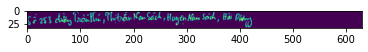

target:     <số 253 đường trần phú, thị trấn nam sách, huyện nam sách, hải dương>
prediction: <số 253 đường trần phú, thị trấn nam sách, huyện nam sách, hải dương>
Bleu Score: 1.0
Word Error Rate: 0.0



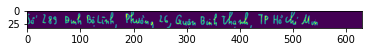

target:     <số 289 đinh bộ lĩnh, phường 26, quận bình thạnh, tp hồ chí minh>
prediction: <số 289 đinh bộ lĩnh, phường 26, quận bình thạnh, tp hồ chí minh>
Bleu Score: 1.0
Word Error Rate: 0.0



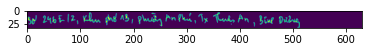

target:     <số 246e/2, khu phố 1b, phường an phú, tx thuận an, bình dương>
prediction: <số 246e/2, khu phố 1b, phường an phú, tx thuận an, bình dương>
Bleu Score: 1.0
Word Error Rate: 0.0



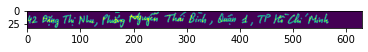

target:     <42 đặng thị nhu, phường nguyễn thái bình, quận 1, tp hồ chí minh>
prediction: <42 đặng thị nhu, phường nguyễn thái bình, quận 1, tp hồ chí minh>
Bleu Score: 1.0
Word Error Rate: 0.0



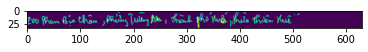

target:     <200 phan bội châu, phường trường an, thành phố huế, thừa thiên  huế>
prediction: <29 đường 32, phường phú thạnh, quận tân phú, tp hồ chí minh>
Bleu Score: 0.3333333333333333
Word Error Rate: 1.0



c:\Users\hungu\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\hungu\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


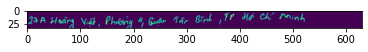

target:     <27a hoàng việt, phường 4, quận tân bình, tp hồ chí minh>
prediction: <27a hoàng việt, phường 4, quận tân bình, tp hồ chí minh>
Bleu Score: 1.0
Word Error Rate: 0.0



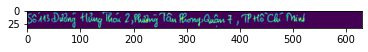

target:     <số 113 đường hưng thái 2, phường tân phong, quận 7, tp hồ chí minh>
prediction: <số 113 đường hưng thái 2, phường tân phong, quận 7, tp hồ chí minh>
Bleu Score: 1.0
Word Error Rate: 0.0



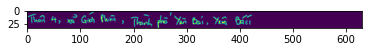

target:     <thôn 4, xã giới phiên, thành phố yên bái, yên bái>
prediction: <thôn 4, xã giới phiên, thành phố yên bái, yên bái>
Bleu Score: 1.0
Word Error Rate: 0.0



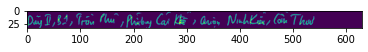

target:     <dãy ii, b1, trần phú, phường cái khế, quận ninh kiều, cần thơ>
prediction: <dãy ii, b1, trần phú, thị trấn hồ, huyện thuận thành, bắc ninh>
Bleu Score: 0.65
Word Error Rate: 0.6153846383094788



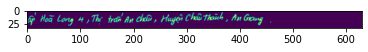

target:     <ấp hòa long 4, thị trấn an châu, huyện châu thành, an giang>
prediction: <ấp hòa long 4, thị trấn an châu, huyện châu thành, an giang>
Bleu Score: 1.0
Word Error Rate: 0.0



In [46]:
def predict(values, labels, n_to_predict):
    """
        input: truyền vào data và số dữ liệu muốn dự đoán
        hàm này sẽ in ra câu mong muốn, câu dự đoán (chúng ta sẽ có thể đánh giá bằng 2 cách 1 là bleu score một cách khác nữa là WORD ERROR RATE)
    """
    ds = create_ds(values[:n_to_predict], labels[:n_to_predict] , n_to_predict)
    
    batch = next(iter(ds))
    # lấy phổ và text của phổ đó
    source = batch["source"]
    target = batch["target"].numpy()
    bs = tf.shape(source)[0]

    idx_to_char = vectorizer.get_vocabulary()

    target_start_token_idx = 10
    target_end_token_idx = 11
    # dự doán dữ liệu truyền vào
    preds = model.generate(source, target_start_token_idx)
    preds = preds.numpy()

    for i in range(bs):
        target_text = "".join([idx_to_char[_] for _ in target[i, :]])
        prediction = ""
        #chuyển vector từ thành câu hoàn chỉnh
        for idx in preds[i, :]:
            prediction += idx_to_char[idx]
            if idx == target_end_token_idx:
                break
        show_from_sub_img(source[i]) # bản chất nó sẽ là màu trắng đen nhưng do plt hiển thị màu là RGB khác với cv2 là BGR nên sẽ có sự sai lệch màu ở góc độ người nhìn
        print(f"target:     {target_text.replace('-','')}")
        print(f"prediction: {prediction}")
        print(f"Bleu Score: {bleu_score(prediction, target_text.replace('-',''))}")
        print(f"Word Error Rate: {wer(prediction, target_text.replace('-',''))}\n")

predict(train_values, train_labels, 10)

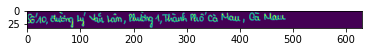

target:     <số 10, đường lý văn lâm, phường 1, thành phố cà mau, cà mau>
prediction: <193 nguyễn đình chính, phường 11, quận phú nhuận, tp hồ chí minh>
Bleu Score: 0.2982797722714565
Word Error Rate: 1.0



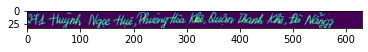

target:     <271 huỳnh ngọc huệ, phường hoà khê, quận thanh khê, đà nẵng>
prediction: <số 199 đường quang trung, phường 13, thành phố đồng hới, quảng bình>
Bleu Score: 0.3333333333333333
Word Error Rate: 1.0



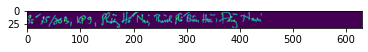

target:     <số 35/70b, kp 9, phường hố nai, thành phố biên hoà, đồng nai>
prediction: <tổ 13, thị trấn hoàn mỹ, huyện đam lâm, hà nội>
Bleu Score: 0.25907159943137514
Word Error Rate: 1.0



c:\Users\hungu\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


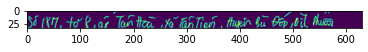

target:     <số 187, tổ 8, ấp tân hòa, xã tân tiến, huyện bù đốp, bình phước>
prediction: <số 96 đường lê hồng phong, phường hà cầu, quận hà đông, hà nội>
Bleu Score: 0.26966515756532683
Word Error Rate: 0.9333333373069763



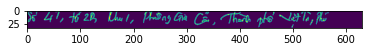

target:     <số 47, tổ 2d, khu 1, phường gia cẩm, thành phố việt trì, phú thọ>
prediction: <tổ 15, thôn thọ hoà, xã thạnh hưng, huyện thạch thành, tây ninh>
Bleu Score: 0.4044977363479903
Word Error Rate: 1.0



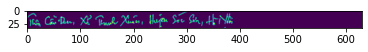

target:     <thôn cầu đen, xã thanh xuân, huyện sóc sơn, hà nội>
prediction: <thôn tân xuyên, xã tân xuân, huyện tân yên, bắc giang>
Bleu Score: 0.5625
Word Error Rate: 0.6363636255264282



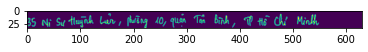

target:     <35 ni sư huỳnh liên, phường 10, quận tân bình, tp hồ chí minh>
prediction: <197 đường 3/1, phường 11, thành phố vũng tàu, bà rịa - vũng tàu>
Bleu Score: 0.3157894736842105
Word Error Rate: 1.0



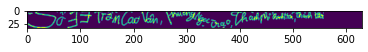

target:     <số 33 trần cao vân, phường ngọc trạo, thành phố thanh hoá, thanh hoá>
prediction: <thôn thánh hưng, xã thánh hòa, huyện lộc nghà, quảng nam>
Bleu Score: 0.25907159943137514
Word Error Rate: 1.0



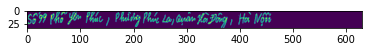

target:     <số 99 phố yên phúc, phường phúc la, quận hà đông, hà nội>
prediction: <thôn tiền phong, xã hải hòa, huyện tân lập, ninh thuận>
Bleu Score: 0.27578028205768607
Word Error Rate: 1.0



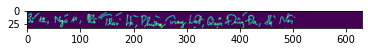

target:     <số 12, ngõ 11, phố thái hà, phường trung liệt, quận đống đa, hà nội>
prediction: <số 79 trần phú, phường mỹ an, thành phố hội an, quảng ngãi>
Bleu Score: 0.35588329018524795
Word Error Rate: 0.9333333373069763



In [47]:
predict(test_values, test_labels, 10)